# Anomaly detection in time-series : reconstruction
This notebook demonstrates anomaly detection in time series using reconstruction methods. Anomaly detection by reconstruction involves training models to reconstruct the values of a time series and identifying anomalies based on deviations between the reconstructed and actual values. The techniques covered include:

- PCA
- AutoEncoders

## Necessary imports

In [44]:
from typing import List, Dict
import warnings

import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Custom modules
from data_preprocessing import DataPreprocessor, SimpleDataSet, DataLoaderNAB
from base_torch_models import Network, LSTMWithEncoder


torch.set_default_dtype(torch.float32)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data
To compare each model, we will use real-life data from the [NAB dataset][nab].

[nab]: https://github.com/numenta/NAB

The specific data used in this notebook is from the `realAdExchange/exchange-3_cpc_results` file. This dataset contains timestamped values representing the cost-per-click (CPC) results over a period of time. The dataset includes:

- `timestamp`: The date and time of the recorded value.
- `value`: The CPC value recorded at the corresponding timestamp.

We will use this data to train and evaluate our anomaly detection models.


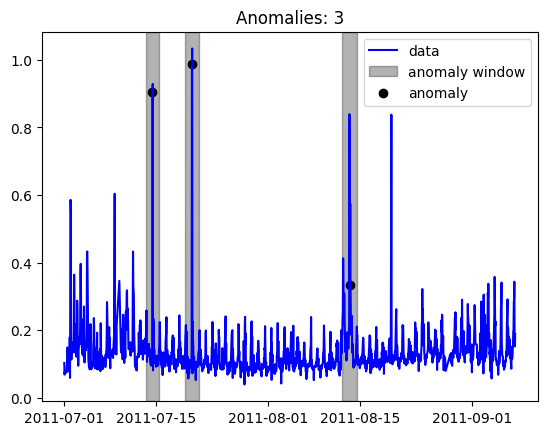

In [45]:
# Use convenience functions to load and visualize the time series
df, anomaly_times, anomaly_windows = DataLoaderNAB.load_data('data.csv', 'anomaly_times.json', 'windows.json')

U = [] # we don't have any external features
Y = df["value"].values

fig, ax = plt.subplots()
DataLoaderNAB.plot_series(df, anomaly_times, anomaly_windows, ax=ax);

In [165]:
# Configurations of the models and the training scheme
n_window = 5 # sequence length for the autoencoder
test_size = 0.3 # percentage of the dataset to use as test set
batch_size = 0.5 # percentage of the training dataset to use as batch size
mlp_activation_fn = torch.relu # activation function for the MLP


def create_AE_dataset(Y, n_window=1, test_size=0.1):
    Ydata = DataPreprocessor.create_AE_model(Y, n_window=n_window)
    Ydata = torch.tensor(Ydata, dtype=torch.float32)

    Ytrain, Yval, = train_test_split(Ydata, test_size=test_size, shuffle=True)

    return Ytrain, Yval, Ydata

def create_dataloaders(Ytrain, Yval, batch_size=10):
    n_samples = len(Ytrain)
    n_batch = round(batch_size * n_samples)
    assert n_batch > 1, "Batch normalization of the model requires batch size greater than 1!"

    train_dl = DataLoader(SimpleDataSet(Ytrain, Ytrain), batch_size=n_batch, shuffle=True)
    val_dl =  DataLoader(SimpleDataSet(Yval, Yval), batch_size=n_batch, shuffle=True)

    return train_dl, val_dl

Ytrain, Yval, Ydata = create_AE_dataset(Y, n_window = 5, test_size=test_size)
train_dl, val_dl = create_dataloaders(Ytrain, Yval, batch_size=batch_size)

## Methods


#### PCA

#### Autoencoders

In [190]:
class AutoEncoder(nn.Module):
    def __init__(self, sequence_length, encoder_layers_list: List, decoder_layers_list: List, activation_fn):
        super().__init__()
        encoder_layers_list.insert(0, sequence_length)
        self.encoder = Network(encoder_layers_list, activation_fn)
        decoder_layers_list.insert(0, encoder_layers_list[-1])
        decoder_layers_list.append(encoder_layers_list[0])
        self.decoder = Network(decoder_layers_list, activation_fn)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class LSTMAutoEncoder(nn.Module):
    def __init__(self,lstm_args: Dict, fc_args: Dict):
        super().__init__()
        self.encoder = nn.LSTM(**lstm_args)
        # if encoder_args["hidden_size"] != decoder_args.get("input_size",None):
            # warnings.warn("Input size of the decoder network must be output size of the encoder network, adjusting decoder arguments accordingly")
            # decoder_args["input_size"] = encoder_args["hidden_size"]
        self.decoder = nn.LSTM(**lstm_args)
        self.h2o = Network(**fc_args)

    def forward(self, x):
        is_2d = False
        if x.ndim == 2:
            # Input is given as (batch_size, sequence_length), map to (batch_size, sequence_length, n_features)
            x = x.view(x.shape[0], x.shape[1], 1)
            is_2d = True
        # Encoding
        _, hidden_states = self.encoder(x)
        # Decoding
        decoder_input = x[:,-1,:].view(x.shape[0], 1, x.shape[2])
        output_sequence = torch.zeros(size=x.shape, dtype=torch.float32)
        for i in range(x.shape[1]-1, -1, -1):
            decoder_out, hidden_states = self.decoder(decoder_input, hidden_states)
            predicted_sequence = self.h2o(decoder_out[:, -1, :])
            output_sequence[:,i,:] = predicted_sequence
            decoder_input = predicted_sequence.view(predicted_sequence.shape[0], 1, predicted_sequence.shape[1])

        if is_2d:
            return output_sequence.view(output_sequence.shape[0], output_sequence.shape[1])
        else:
            return output_sequence



In [192]:
net = AutoEncoder(
    sequence_length=n_window,
    encoder_layers_list=[32, 10],
    decoder_layers_list=[32],
    activation_fn= torch.relu)
net.eval()
print(Ytrain.shape)
net(Ytrain).shape

torch.Size([1073, 5])


torch.Size([1073, 5])

In [191]:
lstm_args = {
    'input_size':1,
    'hidden_size':40,
    'batch_first':True
}

fc_args = {'n_nodes_list':[40, 1],}
net = LSTMAutoEncoder(lstm_args, fc_args)
net.eval()
print(Ytrain.shape)
net(Ytrain).shape

torch.Size([1073, 5])


torch.Size([1073, 5])